## Phase 1: import-load-organize

Objectives:
- prepare the dataset for analysis
- load the matbench band gap dataset
- standardize column names
- convert chemical formulas to composition objects
- generate numerical descriptors using magpie

In [105]:
##import
from matminer.datasets import load_dataset, get_all_dataset_info
import warnings
warnings.filterwarnings("ignore")  ##ignore warnings during featurisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Composition
from matminer.featurizers.composition import ElementProperty
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [106]:
##load

print(get_all_dataset_info("matbench_expt_gap"))
df = load_dataset("matbench_expt_gap")
print("Raw df shape:", df.shape)
display(df.head())
print("Columns:", df.columns.tolist())

Dataset: matbench_expt_gap
Description: Matbench v0.1 test dataset for predicting experimental band gap from composition alone. Retrieved from Zhuo et al. supplementary information. Deduplicated according to composition, removing compositions with reported band gaps spanning more than a 0.1eV range; remaining compositions were assigned values based on the closest experimental value to the mean experimental value for that composition among all reports. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gap expt: Target variable. Experimentally measured gap, in eV.
Num Entries: 4604
Reference: Y. Zhuo, A. Masouri Tehrani, J. Brgoch (2018) Predicting the Band Gaps of Inorganic Solids by Machine Learning J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673 https:doi.org/10.1021/acs.jpclett.8b00124.
Bibtex citations: ["@Article{Dunn2020

,composition,gap expt
0,Ag(AuS)2,0.00
1,Ag(W3Br7)2,0.00
2,Ag0.5Ge1Pb1.75S4,1.83
3,Ag0.5Ge1Pb1.75Se4,1.51
4,Ag2BBr,0.00


Columns: ['composition', 'gap expt']


In [107]:
df.rename({"composition": "formula"}, axis=1, inplace=True)
df["composition"] = [Composition(comp) for comp in df["formula"]]
print("After adding composition_obj:", df.shape)
display(df.head())

ep = ElementProperty.from_preset("magpie")
ep.set_n_jobs(1)
ep.featurize_dataframe(df, col_id="composition", inplace=True)
df
print("After Magpie featurization:", df.shape)
display(df.head())


After adding composition_obj: (4604, 3)


,formula,gap expt,composition
0,Ag(AuS)2,0.00,"(Ag, Au, S)"
1,Ag(W3Br7)2,0.00,"(Ag, W, Br)"
2,Ag0.5Ge1Pb1.75S4,1.83,"(Ag, Ge, Pb, S)"
3,Ag0.5Ge1Pb1.75Se4,1.51,"(Ag, Ge, Pb, Se)"
4,Ag2BBr,0.00,"(Ag, B, Br)"


ElementProperty:   0%|          | 0/4604 [00:00<?, ?it/s]

After Magpie featurization: (4604, 135)


,formula,gap expt,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Ag(AuS)2,0.00,"(Ag, Au, S)",16.0,79.0,63.0,47.400000,25.280000,16.0,65.0,...,0.0,0.0,0.0,0.0,70.0,225.0,155.0,163.000000,74.400000,70.0
1,Ag(W3Br7)2,0.00,"(Ag, W, Br)",35.0,74.0,39.0,46.714286,15.619048,35.0,51.0,...,0.0,0.0,0.0,0.0,64.0,229.0,165.0,118.809524,73.079365,64.0
2,Ag0.5Ge1Pb1.75S4,1.83,"(Ag, Ge, Pb, S)",16.0,82.0,66.0,36.275862,23.552913,16.0,65.0,...,0.0,0.0,0.0,0.0,70.0,225.0,155.0,139.482759,76.670630,70.0
3,Ag0.5Ge1Pb1.75Se4,1.51,"(Ag, Ge, Pb, Se)",32.0,82.0,50.0,46.206897,17.388823,34.0,65.0,...,0.0,0.0,0.0,0.0,14.0,225.0,211.0,108.586207,104.370987,14.0
4,Ag2BBr,0.00,"(Ag, B, Br)",5.0,47.0,42.0,33.500000,14.250000,47.0,65.0,...,0.0,0.0,0.0,0.0,64.0,225.0,161.0,170.000000,55.000000,225.0


# Phase 2: overview-cleaning

Objectives:
- understand the distribution and ensure the dataset is okay for ML
- inspect the band gap distribution
- identify zero-inflation
- remove non-numeric and constant features
- standardize all features

In [108]:
print(df.columns.tolist())

columns_drop = ["formula", "composition", "gap expt"] ##drop non-numeric and target columns
X = df.drop(columns=columns_drop) 
X = X.select_dtypes(include=[np.number]) ##keep only numeric columns
y = df["gap expt"].values ##target 

print("X shape:", X.shape) 
print("y shape:", y.shape) 
print("Any NaNs in X?", X.isna().any().any())


['formula', 'gap expt', 'composition', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'MagpieData minimum Column', 'MagpieData maximum Column', 'MagpieData range Column', 'MagpieData mean Column', 'MagpieData avg_dev Column', 'MagpieData mode Column', 'MagpieData minimum Row', 'Ma

count    4604.000000
mean        0.975951
std         1.445034
min         0.000000
25%         0.000000
50%         0.000000
75%         1.812500
max        11.700000
dtype: float64
Fraction of materials with band gap ≤ 0.1 eV: 0.537


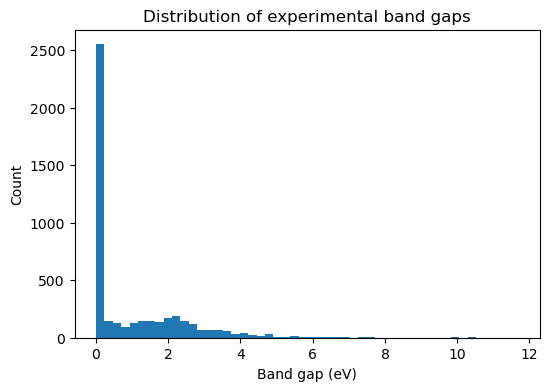

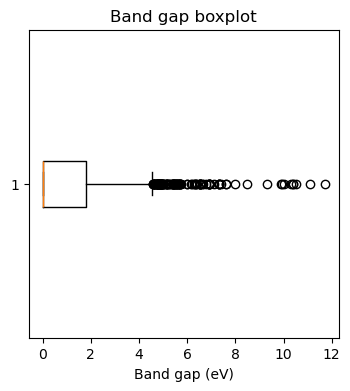

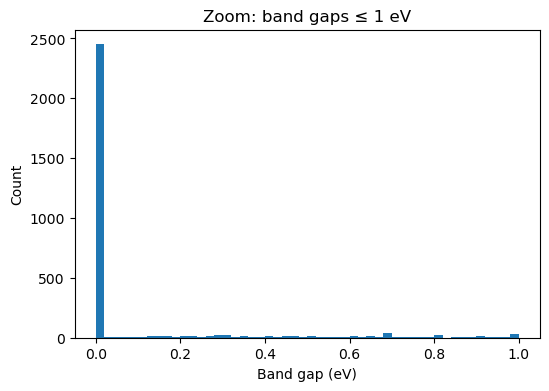

In [109]:
y_series = pd.Series(y) 

print(y_series.describe())

##fraction of materials with band gap near zero (metals?)
eps = 0.1
frac_near_zero = np.mean(y <= eps)
print(f"Fraction of materials with band gap ≤ {eps} eV: {frac_near_zero:.3f}")

##visualise target distribution
plt.figure(figsize=(6,4))
plt.hist(y, bins=50)
plt.xlabel("Band gap (eV)")
plt.ylabel("Count")
plt.title("Distribution of experimental band gaps")
plt.show()

##boxplot
plt.figure(figsize=(4,4))
plt.boxplot(y, vert=False)
plt.xlabel("Band gap (eV)")
plt.title("Band gap boxplot")
plt.show()

##zoom in on low band gap region
plt.figure(figsize=(6,4))
plt.hist(y[y <= 1.0], bins=50)
plt.xlabel("Band gap (eV)")
plt.ylabel("Count")
plt.title("Zoom: band gaps ≤ 1 eV")
plt.show()

In [110]:
constant_cols = X.columns[X.nunique() == 1] ##identify and remove constant columns
print("Number of constant columns:", len(constant_cols))
X_clean = X.drop(columns=constant_cols)

print("X_clean shape:", X_clean.shape)


Number of constant columns: 0
X_clean shape: (4604, 132)


In [111]:
scaler = StandardScaler() ##standardise features so they have mean=0 and std=1
X_scaled = scaler.fit_transform(X_clean) 

print("X_scaled shape:", X_scaled.shape)

X_scaled shape: (4604, 132)


# Phase 3: correlations

Objectives:
- reduce feature redundancy by removing highly correlated descriptors
- correlation matrix
- identify near-duplicate descriptors (|r|>0.95) --used this to be conservative
- remove redundant features
- verify the remaining correlation structure

*Note*: many Magpie descriptors represent different statistical summaries (mean, max, mode, range, etc.) of the same underlying chemical property, they weren't removed with the r criteria, but it's possible to remove with correlation-based grouping (clustering similar descriptors and keeping one representative per group) or woth property-based selection (statistical summary most correlated with the target for each property).


Correlation matrix shape: (132, 132)


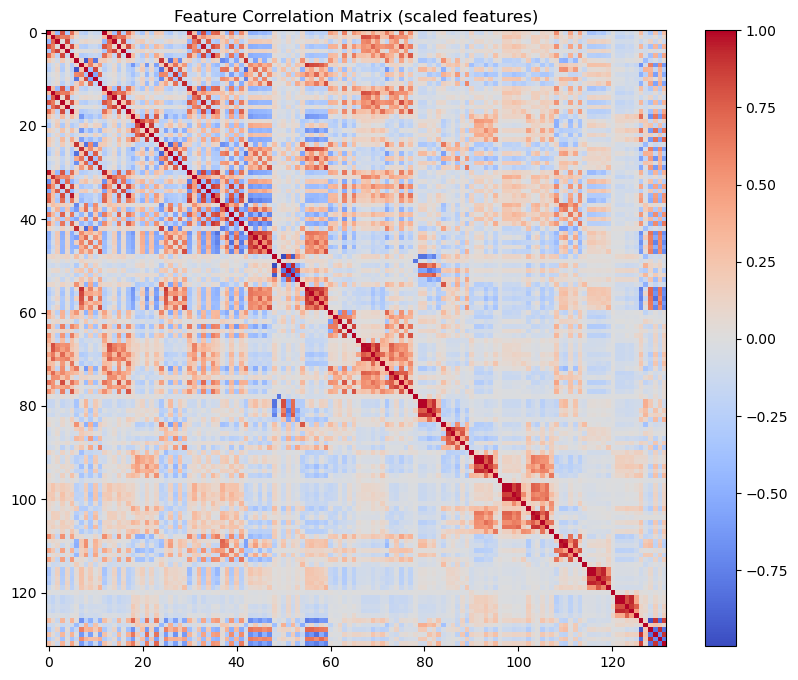

In [112]:
corr_matrix = pd.DataFrame(X_scaled, columns=X_clean.columns).corr() ##correlation matrix for scaled features
print("Correlation matrix shape:", corr_matrix.shape)

plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Feature Correlation Matrix (scaled features)") 
plt.show() ##heatmap of correlation matrix before feature correlation analysis

In [113]:
threshold = 0.95 

high_corr_cols = []
cols = list(corr_matrix.columns) 

for i in range(len(cols)): #remove one of each pair of highly correlated features
    for j in range(i+1, len(cols)):
        r = corr_matrix.loc[cols[i], cols[j]]
        if abs(r) > threshold:
            high_corr_cols.append(cols[j])

high_corr_cols = list(set(high_corr_cols))

print("Threshold |r| >", threshold) 
print("Number of highly correlated columns (excluded):", len(high_corr_cols))

X_uncorr = X_clean.drop(columns=high_corr_cols)
print("X_uncorr shape:", X_uncorr.shape)

Threshold |r| > 0.95
Number of highly correlated columns (excluded): 18
X_uncorr shape: (4604, 114)


X_uncorr_scaled shape: (4604, 114)
Updated correlation matrix shape: (114, 114)


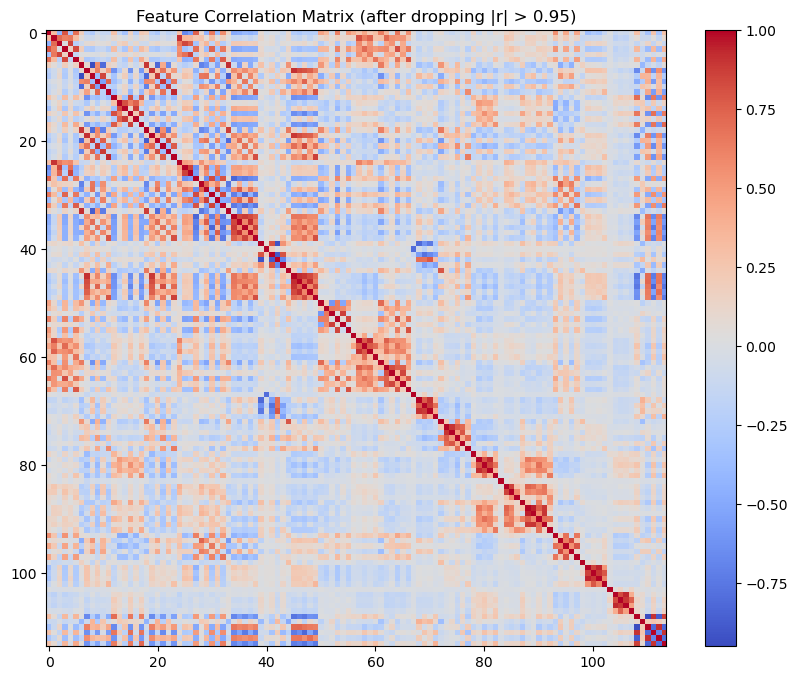

In [114]:
X_uncorr_scaled = scaler.fit_transform(X_uncorr)
print("X_uncorr_scaled shape:", X_uncorr_scaled.shape)

###correlation matrix after removing highly correlated features
corr_matrix_uncorr = pd.DataFrame(X_uncorr_scaled, columns=X_uncorr.columns).corr()
print("Updated correlation matrix shape:", corr_matrix_uncorr.shape)

plt.figure(figsize=(10,8))
plt.imshow(corr_matrix_uncorr, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Feature Correlation Matrix (after dropping |r| > 0.95)")
plt.show()

In [115]:
#compare max off-diagonal correlation before and after correlation analysis
max_offdiag_before = np.max(np.abs(corr_matrix.values - np.eye(corr_matrix.shape[0])))
max_offdiag_after  = np.max(np.abs(corr_matrix_uncorr.values - np.eye(corr_matrix_uncorr.shape[0])))

print("Max |corr| off-diagonal BEFORE:", max_offdiag_before)
print("Max |corr| off-diagonal AFTER :", max_offdiag_after)

Max |corr| off-diagonal BEFORE: 0.9993251994036717
Max |corr| off-diagonal AFTER : 0.9496545525477645


In [116]:
removed_summary = []

for feat in high_corr_cols: ##for each removed feature, find the feature it was most correlated with
    best_abs = 0
    best_partner = None
    best_r = None
    
    for other in cols:
        if other != feat:
            r = corr_matrix.loc[feat, other]
            if abs(r) > best_abs:
                best_abs = abs(r)
                best_partner = other
                best_r = r
    
    removed_summary.append((feat, best_partner, best_r, best_abs))

removed_df = pd.DataFrame(
    removed_summary,
    columns=["removed_feature", "most_correlated_with", "corr", "abs_corr"]
).sort_values("abs_corr", ascending=False)

display(removed_df.head(30))

,removed_feature,most_correlated_with,corr,abs_corr
9,MagpieData range NfUnfilled,MagpieData maximum NfUnfilled,0.999325,0.999325
5,MagpieData maximum AtomicWeight,MagpieData maximum Number,0.999292,0.999292
16,MagpieData range GSmagmom,MagpieData maximum GSmagmom,0.998917,0.998917
6,MagpieData mean AtomicWeight,MagpieData mean Number,0.998773,0.998773
2,MagpieData range GSbandgap,MagpieData maximum GSbandgap,0.998767,0.998767
4,MagpieData mode AtomicWeight,MagpieData mode Number,0.998651,0.998651
11,MagpieData minimum AtomicWeight,MagpieData minimum Number,0.997903,0.997903
1,MagpieData range NsUnfilled,MagpieData maximum NsUnfilled,0.996918,0.996918
10,MagpieData avg_dev AtomicWeight,MagpieData avg_dev Number,0.996462,0.996462
7,MagpieData range NsValence,MagpieData minimum NsValence,-0.996191,0.996191


In [117]:
pairs = []
cols_uncorr = list(corr_matrix_uncorr.columns)
for i in range(len(cols_uncorr)): ##list all remaining feature pairs and their correlations
    for j in range(i+1, len(cols_uncorr)):
        r = corr_matrix_uncorr.loc[cols_uncorr[i], cols_uncorr[j]]
        pairs.append((cols_uncorr[i], cols_uncorr[j], r, abs(r)))

remaining_corr_df = pd.DataFrame(
    pairs, columns=["feature_1", "feature_2", "corr", "abs_corr"]
)
remaining_corr_df = remaining_corr_df.sort_values("abs_corr", ascending=False)
display(remaining_corr_df.head(10))

,feature_1,feature_2,corr,abs_corr
6427,MagpieData minimum SpaceGroupNumber,MagpieData range SpaceGroupNumber,-0.949655,0.949655
6116,MagpieData maximum NUnfilled,MagpieData range NUnfilled,0.948540,0.948540
664,MagpieData minimum MendeleevNumber,MagpieData range MendeleevNumber,-0.943146,0.943146
6337,MagpieData maximum GSbandgap,MagpieData avg_dev GSbandgap,0.939996,0.939996
6397,MagpieData maximum GSmagmom,MagpieData avg_dev GSmagmom,0.935481,0.935481
1199,MagpieData mode MendeleevNumber,MagpieData mode Column,0.931999,0.931999
3361,MagpieData range Electronegativity,MagpieData avg_dev Electronegativity,0.927010,0.927010
5847,MagpieData maximum NdUnfilled,MagpieData avg_dev NdUnfilled,0.924436,0.924436
4095,MagpieData maximum NpValence,MagpieData range NpValence,0.921406,0.921406
6436,MagpieData range SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,0.918448,0.918448


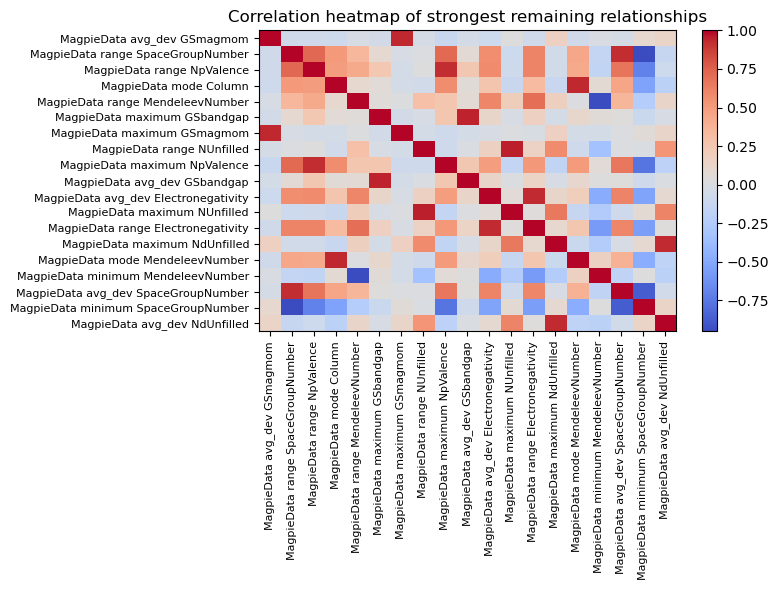

In [118]:
##visualise strongest remaining correlations (10 in this case)
top_features_corr = list(set(
    remaining_corr_df.head(10)["feature_1"].tolist() +
    remaining_corr_df.head(10)["feature_2"].tolist()
))
sub_corr = corr_matrix_uncorr.loc[top_features_corr, top_features_corr]

plt.figure(figsize=(8,6))
plt.imshow(sub_corr, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Correlation heatmap of strongest remaining relationships")
plt.xticks(range(len(top_features_corr)), top_features_corr, rotation=90, fontsize=8)
plt.yticks(range(len(top_features_corr)), top_features_corr, fontsize=8)
plt.tight_layout()
plt.show()

# Phase 4: feature engineering

Objective:
- identify most relevant descriptors for predicting the band gap (in this case, 10)
- rank features by correlation with the target
- select top 10 descriptors
- visualize feature importance
- inspect chemical trends

In [119]:
X_uncorr_df = pd.DataFrame(X_uncorr_scaled, columns=X_uncorr.columns)
corr_with_y = []

for col in X_uncorr_df.columns: ##for each remaining feature, compute correlation with the band gap
    r = np.corrcoef(X_uncorr_df[col].values, y)[0, 1]
    corr_with_y.append(r)

##rank features by absolute correlation with target
feat_rank = pd.DataFrame({
    "feature": X_uncorr_df.columns,
    "corr_with_y": corr_with_y,
    "abs_corr_with_y": np.abs(corr_with_y)
})

feat_rank = feat_rank.sort_values("abs_corr_with_y", ascending=False)

display(feat_rank.head(30))

,feature,corr_with_y,abs_corr_with_y
47,MagpieData mean NpValence,0.458913,0.458913
111,MagpieData mean SpaceGroupNumber,-0.439529,0.439529
45,MagpieData maximum NpValence,0.422002,0.422002
113,MagpieData mode SpaceGroupNumber,-0.414991,0.414991
15,MagpieData mean MeltingT,-0.405884,0.405884
49,MagpieData mode NpValence,0.394536,0.394536
46,MagpieData range NpValence,0.389805,0.389805
108,MagpieData minimum SpaceGroupNumber,-0.387766,0.387766
7,MagpieData maximum MendeleevNumber,0.373902,0.373902
110,MagpieData range SpaceGroupNumber,0.362233,0.362233


In [120]:
top_n = 20 ##select top N features
top_features = feat_rank["feature"].head(top_n).tolist()
print("Top features selected:", len(top_features)) 
top_features_frame = feat_rank.head(top_n) ##dataframe of top features
display(top_features_frame)

X_top = X_uncorr_df[top_features].values
print("X_top shape:", X_top.shape) ###final feature matrix with top N features

Top features selected: 20


,feature,corr_with_y,abs_corr_with_y
47,MagpieData mean NpValence,0.458913,0.458913
111,MagpieData mean SpaceGroupNumber,-0.439529,0.439529
45,MagpieData maximum NpValence,0.422002,0.422002
113,MagpieData mode SpaceGroupNumber,-0.414991,0.414991
15,MagpieData mean MeltingT,-0.405884,0.405884
49,MagpieData mode NpValence,0.394536,0.394536
46,MagpieData range NpValence,0.389805,0.389805
108,MagpieData minimum SpaceGroupNumber,-0.387766,0.387766
7,MagpieData maximum MendeleevNumber,0.373902,0.373902
110,MagpieData range SpaceGroupNumber,0.362233,0.362233


X_top shape: (4604, 20)


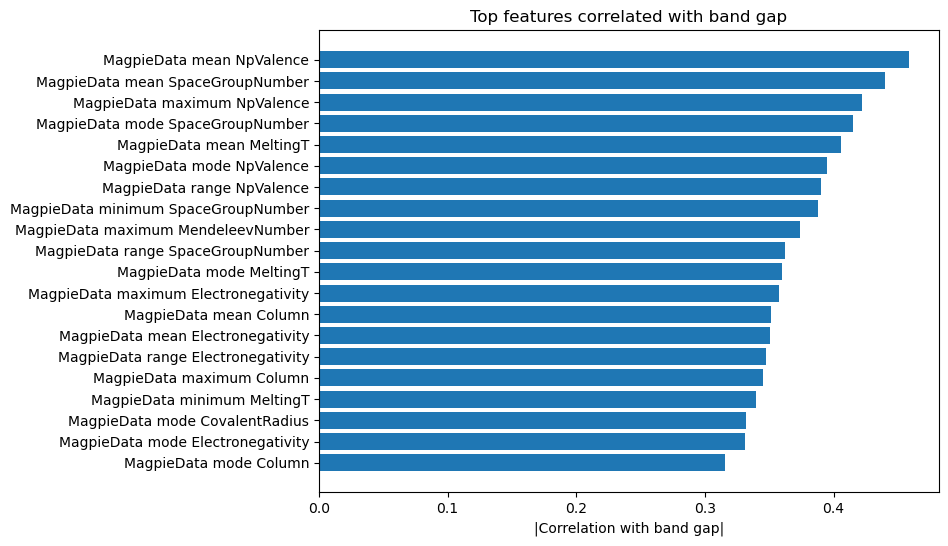

In [121]:
#visualise top features correlation with band gap
plt.figure(figsize=(8,6))
plt.barh(top_features_frame["feature"], top_features_frame["abs_corr_with_y"])
plt.xlabel("|Correlation with band gap|")
plt.title("Top features correlated with band gap")
plt.gca().invert_yaxis()
plt.show()

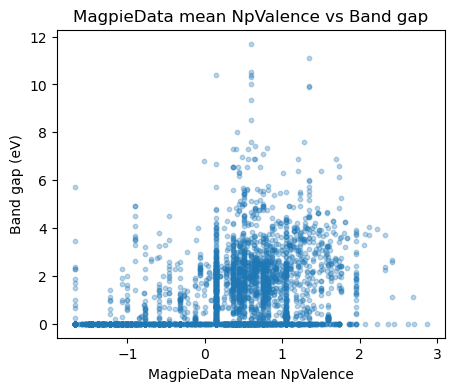

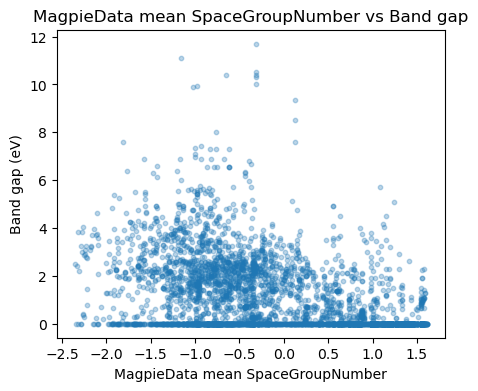

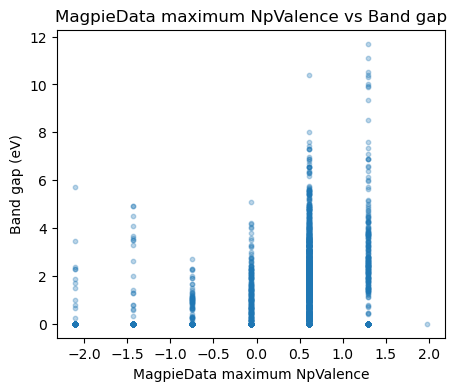

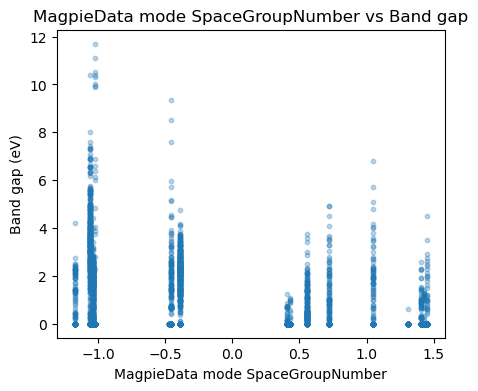

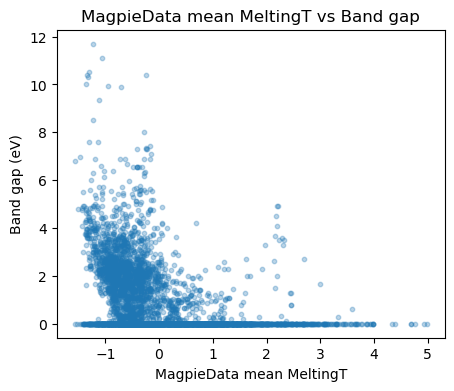

In [122]:
##scatter plots of top 5 features vs band gap
for feat in top_features_frame["feature"][:5]:
    plt.figure(figsize=(5,4))
    plt.scatter(X_uncorr_df[feat], y, alpha=0.3, s=10)
    plt.xlabel(feat)
    plt.ylabel("Band gap (eV)")
    plt.title(f"{feat} vs Band gap")
    plt.show()

# Phase 5: PCA

Objective:
- reduce dimensionality and visualize the structure of the data
- apply PCA
- analyse explained variance
- select the number of components
- visualize PCs

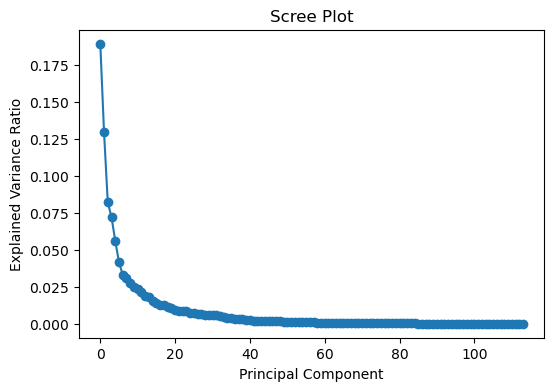

In [123]:
pca = PCA() ###PCA on uncorrelated scaled features
X_pca = pca.fit_transform(X_uncorr_scaled) 

##scree plot
plt.figure(figsize=(6,4))
plt.plot(pca.explained_variance_ratio_, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.show()

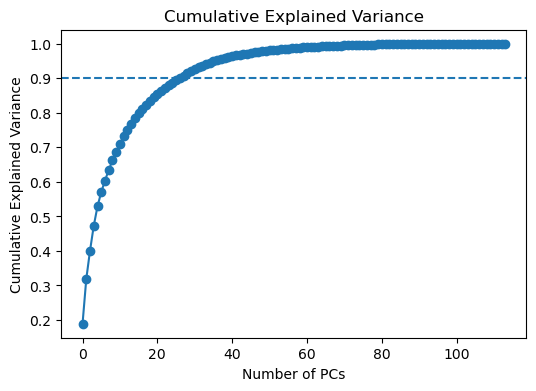

In [124]:
##accumulated explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

#plot cumulative explained variance
plt.figure(figsize=(6,4))
plt.plot(cum_var, marker="o")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.axhline(0.9, linestyle="--")
plt.show()

In [125]:
n_90 = np.argmax(cum_var >= 0.9) + 1 ##number of PCs to reach 90% variance (reduce PCA)
print("Number of PCs for 90% variance:", n_90)

pca_red = PCA(n_components=n_90) ##PCA with reduced number of components
X_pca_red = pca_red.fit_transform(X_uncorr_scaled) 
print("X_pca_red shape:", X_pca_red.shape)

Number of PCs for 90% variance: 27
X_pca_red shape: (4604, 27)


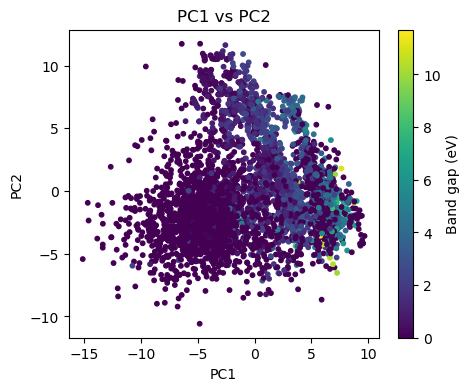

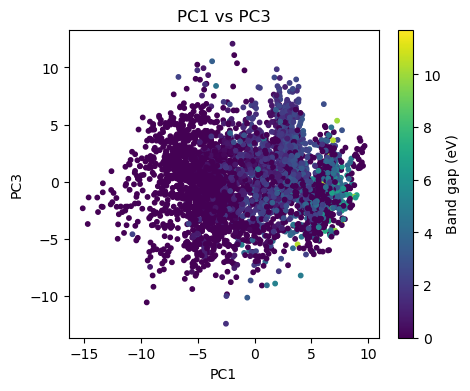

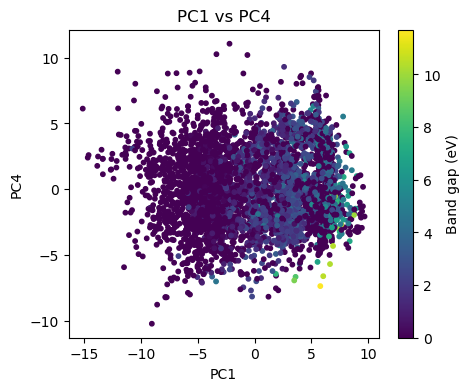

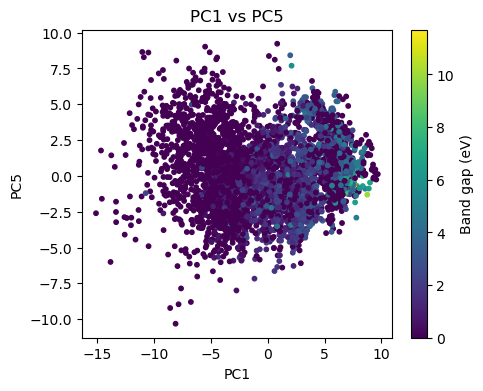

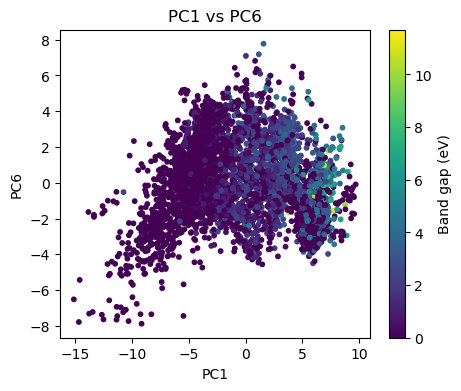

In [169]:
pairs = [(0,1), (0,2), (0,3), (0,4), (0,5)] ##can change pairs to visualise other PC combinations

for i, j in pairs: #scatter plots of selected PC pairs colored by band gap
    plt.figure(figsize=(5,4))
    plt.scatter(X_pca_red[:,i], X_pca_red[:,j], c=y, cmap="viridis", s=10)
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"PC{i+1} vs PC{j+1}")
    plt.colorbar(label="Band gap (eV)")
    plt.show()

In [172]:
loadings = pd.DataFrame(
    pca_red.components_.T,
    index=X_uncorr.columns,
    columns=[f"PC{i+1}" for i in range(pca_red.n_components_)]
) ##loadings are the weights of each original feature in the PCs

for pc in loadings.columns: ##display top 3 features contributing to each PC
    top3 = loadings[pc].abs().sort_values(ascending=False).head(3).index
    pc_table = pd.DataFrame({
        "feature": top3,
        "loading": [loadings.loc[f, pc] for f in top3],
        "abs_loading": [abs(loadings.loc[f, pc]) for f in top3]
    })

    display(pc_table.style.hide(axis="index").format({"loading": "{:.3f}", "abs_loading": "{:.3f}"}))

feature,loading,abs_loading
MagpieData maximum Electronegativity,0.182,0.182
MagpieData range Electronegativity,0.176,0.176
MagpieData mode CovalentRadius,-0.174,0.174


feature,loading,abs_loading
MagpieData minimum Column,0.217,0.217
MagpieData mean MendeleevNumber,0.204,0.204
MagpieData minimum MendeleevNumber,0.197,0.197


feature,loading,abs_loading
MagpieData mean GSvolume_pa,0.233,0.233
MagpieData range NValence,0.191,0.191
MagpieData maximum GSvolume_pa,0.188,0.188


feature,loading,abs_loading
MagpieData avg_dev Number,0.230,0.230
MagpieData maximum Number,0.230,0.230
MagpieData maximum Row,0.223,0.223


feature,loading,abs_loading
MagpieData range Number,0.193,0.193
MagpieData maximum NfValence,0.184,0.184
MagpieData avg_dev Number,0.180,0.180


feature,loading,abs_loading
MagpieData maximum NpUnfilled,0.233,0.233
MagpieData mean GSbandgap,0.216,0.216
MagpieData avg_dev GSbandgap,0.209,0.209


feature,loading,abs_loading
MagpieData mean GSmagmom,0.301,0.301
MagpieData avg_dev GSmagmom,0.300,0.300
MagpieData maximum GSmagmom,0.292,0.292


feature,loading,abs_loading
MagpieData range NpUnfilled,0.343,0.343
MagpieData avg_dev NpUnfilled,0.335,0.335
MagpieData maximum NpUnfilled,0.299,0.299


feature,loading,abs_loading
MagpieData avg_dev NdValence,0.227,0.227
MagpieData mean GSbandgap,-0.214,0.214
MagpieData avg_dev NUnfilled,0.210,0.210


feature,loading,abs_loading
MagpieData mode NpUnfilled,0.313,0.313
MagpieData mode Column,0.247,0.247
MagpieData mode MendeleevNumber,0.236,0.236


feature,loading,abs_loading
MagpieData mean GSmagmom,0.318,0.318
MagpieData avg_dev GSmagmom,0.274,0.274
MagpieData mode GSmagmom,0.273,0.273


feature,loading,abs_loading
MagpieData range NdValence,0.336,0.336
MagpieData avg_dev NdValence,0.299,0.299
MagpieData minimum NdValence,-0.236,0.236


feature,loading,abs_loading
MagpieData mode NUnfilled,0.316,0.316
MagpieData mode NdUnfilled,0.258,0.258
MagpieData minimum NUnfilled,0.218,0.218


feature,loading,abs_loading
MagpieData mode NfUnfilled,0.367,0.367
MagpieData mean NfUnfilled,0.298,0.298
MagpieData mode NfValence,0.282,0.282


feature,loading,abs_loading
MagpieData minimum NsUnfilled,0.662,0.662
MagpieData maximum NsValence,-0.648,0.648
MagpieData avg_dev NsValence,-0.137,0.137


feature,loading,abs_loading
MagpieData avg_dev GSvolume_pa,0.316,0.316
MagpieData range CovalentRadius,0.245,0.245
MagpieData maximum GSvolume_pa,0.241,0.241


feature,loading,abs_loading
MagpieData avg_dev MeltingT,0.353,0.353
MagpieData range MeltingT,0.328,0.328
MagpieData mode NdUnfilled,-0.272,0.272


feature,loading,abs_loading
MagpieData minimum NpUnfilled,0.260,0.260
MagpieData mode NfValence,0.246,0.246
MagpieData minimum NpValence,0.229,0.229


feature,loading,abs_loading
MagpieData minimum NfValence,0.411,0.411
MagpieData mode NdValence,-0.269,0.269
MagpieData minimum NUnfilled,0.266,0.266


feature,loading,abs_loading
MagpieData minimum MeltingT,0.287,0.287
MagpieData mode MeltingT,0.215,0.215
MagpieData avg_dev Column,0.212,0.212


feature,loading,abs_loading
MagpieData minimum GSmagmom,0.697,0.697
MagpieData minimum GSbandgap,0.306,0.306
MagpieData minimum NdUnfilled,0.207,0.207


feature,loading,abs_loading
MagpieData minimum NfUnfilled,0.769,0.769
MagpieData minimum GSmagmom,-0.247,0.247
MagpieData minimum NUnfilled,0.167,0.167


feature,loading,abs_loading
MagpieData minimum GSmagmom,0.446,0.446
MagpieData minimum GSbandgap,-0.348,0.348
MagpieData mode NsUnfilled,0.256,0.256


feature,loading,abs_loading
MagpieData minimum NfUnfilled,0.497,0.497
MagpieData minimum GSmagmom,0.389,0.389
MagpieData avg_dev SpaceGroupNumber,-0.262,0.262


feature,loading,abs_loading
MagpieData minimum GSbandgap,0.460,0.460
MagpieData minimum NfValence,0.269,0.269
MagpieData mode NdValence,-0.234,0.234


feature,loading,abs_loading
MagpieData mode NsUnfilled,0.452,0.452
MagpieData maximum SpaceGroupNumber,-0.283,0.283
MagpieData mode NfValence,-0.265,0.265


feature,loading,abs_loading
MagpieData minimum NdUnfilled,0.297,0.297
MagpieData avg_dev GSvolume_pa,0.273,0.273
MagpieData maximum SpaceGroupNumber,0.259,0.259


# Phase 6: k-means clustering

Objectives:

- identify natural groupings of materials based on their chemical descriptors
- test multiple clusters
- use the elbow method and silhouette score
- train the final k-means model
- assign labels

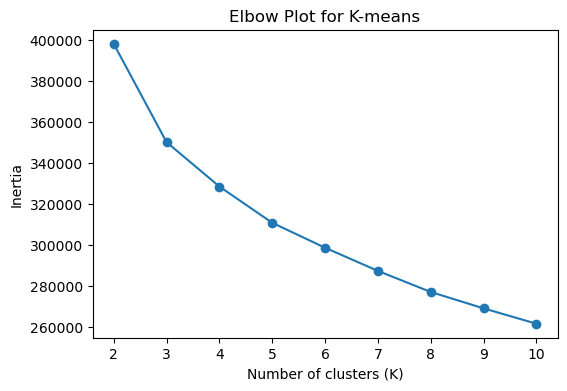

In [127]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_red)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Plot for K-means")
plt.show()

NOTE: the elbow is not well defined, we can see a clear reduction around K = 3-5. 
With k=3 we could separate metals/semiconductors/insulating
with k=5 we could separate oxide/sulfide/halides

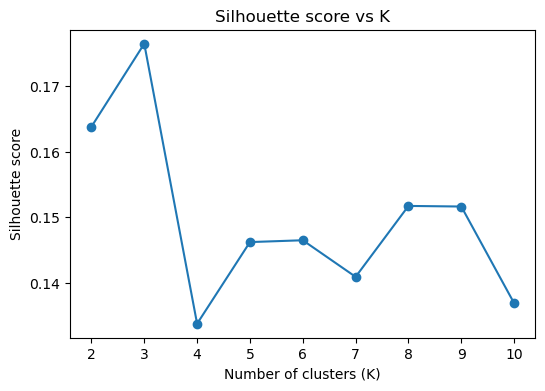

K,silhouette
2,0.164
3,0.176
4,0.134
5,0.146
6,0.147
7,0.141
8,0.152
9,0.152
10,0.137


In [173]:
K_range = range(2, 11)
sil_scores = []
for k in K_range: ##compute silhouette scores for different K
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca_red)
    sil = silhouette_score(X_pca_red, labels)
    sil_scores.append(sil)

#plot silhouette scores vs K
plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs K")
plt.show()
sil_table = pd.DataFrame({"K": list(K_range), "silhouette": sil_scores})
display(sil_table.style.hide(axis="index").format({"silhouette": "{:.3f}"}))

Clusters (K=3) shape: (4604,)


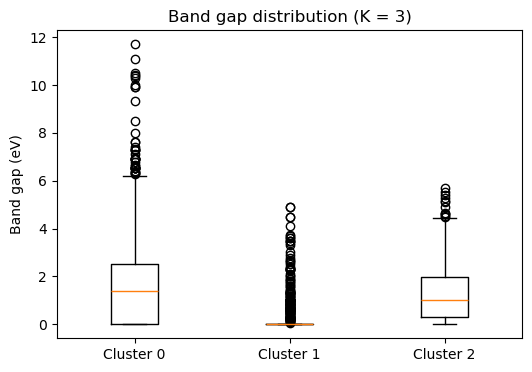

In [128]:
###K-means clustering with K=3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_3 = kmeans_3.fit_predict(X_pca_red)
print("Clusters (K=3) shape:", clusters_3.shape)

#boxplot
df["cluster_3"] = clusters_3
plt.figure(figsize=(6,4))
plt.boxplot(
    [df[df["cluster_3"] == i]["gap expt"] for i in range(3)],
    labels=[f"Cluster {i}" for i in range(3)]
)
plt.ylabel("Band gap (eV)")
plt.title("Band gap distribution (K = 3)")
plt.show()


Clusters (K=5) shape: (4604,)


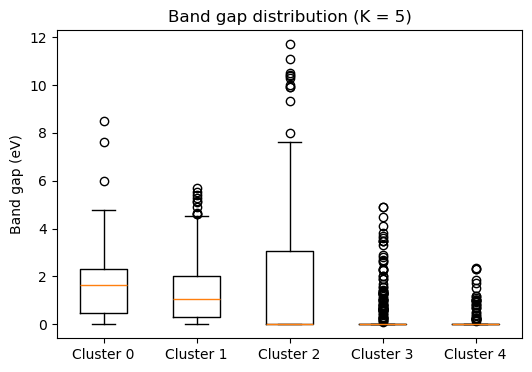

In [129]:
###k-means with K=5
kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_5 = kmeans_5.fit_predict(X_pca_red)
print("Clusters (K=5) shape:", clusters_5.shape)

#boxplot 
df["cluster_5"] = clusters_5
plt.figure(figsize=(6,4))
plt.boxplot(
    [df[df["cluster_5"] == i]["gap expt"] for i in range(5)],
    labels=[f"Cluster {i}" for i in range(5)]
)
plt.ylabel("Band gap (eV)")
plt.title("Band gap distribution (K = 5)")
plt.show()

In [143]:
rows = []
eps=0.1

#for k=3
sil_3 = silhouette_score(X_pca_red, clusters_3)
inertia_3 = kmeans_3.inertia_

for c in sorted(np.unique(clusters_3)):
    gaps = df[df["cluster_3"] == c]["gap expt"]
    row = {
        "K": 3,
        "cluster": c,
        "size": len(gaps),
        "mean_gap": gaps.mean(),
        "median_gap": gaps.median(),
        "std_gap": gaps.std(),
        "min_gap": gaps.min(),
        "max_gap": gaps.max(),
        "frac_gap_less_0.1": (gaps <= eps).mean(),
        "inertia": inertia_3,
        "silhouette": sil_3
    }
    rows.append(row)

#for k=5
sil_5 = silhouette_score(X_pca_red, clusters_5)
inertia_5 = kmeans_5.inertia_

for c in sorted(np.unique(clusters_5)):
    gaps = df[df["cluster_5"] == c]["gap expt"]
    row = {
        "K": 5,
        "cluster": c,
        "size": len(gaps),
        "mean_gap": gaps.mean(),
        "median_gap": gaps.median(),
        "std_gap": gaps.std(),
        "min_gap": gaps.min(),
        "max_gap": gaps.max(),
        "frac_gap_less_0.1": (gaps <= eps).mean(),
        "inertia": inertia_5,
        "silhouette": sil_5
    }
    rows.append(row)

comparison_table = pd.DataFrame(rows)
display(comparison_table.style.hide(axis="index"))  

K,cluster,size,mean_gap,median_gap,std_gap,min_gap,max_gap,frac_gap_less_0.1,inertia,silhouette
3,0,2047,1.550845,1.400000,1.728584,0.000000,11.700000,0.407426,350319.759030,0.176419
3,1,1643,0.112946,0.000000,0.488207,0.000000,4.900000,0.911747,350319.759030,0.176419
3,2,914,1.239748,1.000000,1.118893,0.000000,5.700000,0.152079,350319.759030,0.176419
5,0,1011,1.512957,1.660000,1.101544,0.000000,8.500000,0.221563,310984.314804,0.146237
5,1,894,1.277953,1.045000,1.128984,0.000000,5.700000,0.136465,310984.314804,0.146237
5,2,1118,1.496297,0.000000,2.120628,0.000000,11.700000,0.587657,310984.314804,0.146237
5,3,799,0.148335,0.000000,0.587509,0.000000,4.900000,0.901126,310984.314804,0.146237
5,4,782,0.038120,0.000000,0.221625,0.000000,2.370000,0.956522,310984.314804,0.146237


it seems like k=3 defines better clusters (higher silhouette score)

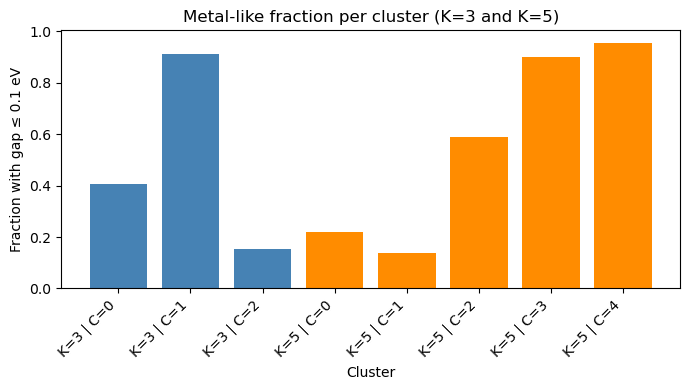

In [146]:
tbl = comparison_table.copy()
tbl["cluster_id"] = "K=" + tbl["K"].astype(str) + " | C=" + tbl["cluster"].astype(str) 

#visualise fraction of metals (gap ≤ 0.1 eV) per cluster
colors = ["steelblue" if k == 3 else "darkorange" for k in tbl["K"]]
plt.figure(figsize=(7,4))
plt.bar(tbl["cluster_id"], tbl["frac_gap_less_0.1"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Fraction with gap ≤ 0.1 eV")
plt.title("Metal-like fraction per cluster (K=3 and K=5)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


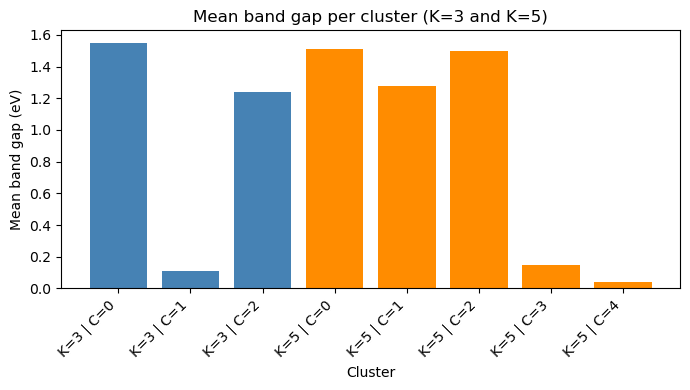

In [149]:
tbl = comparison_table.copy()
tbl["cluster_id"] = "K=" + tbl["K"].astype(str) + " | C=" + tbl["cluster"].astype(str)

#visualise mean band gap per cluster
colors = ["steelblue" if k == 3 else "darkorange" for k in tbl["K"]]
plt.figure(figsize=(7,4))
plt.bar(tbl["cluster_id"], tbl["mean_gap"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Mean band gap (eV)")
plt.title("Mean band gap per cluster (K=3 and K=5)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Phase 7: visualization

Objectives:
- interpret the clusters and PCA
- visualize clusters in PCA
- compare band gaps per cluster
- relate findings to materials (metal/non-metal)

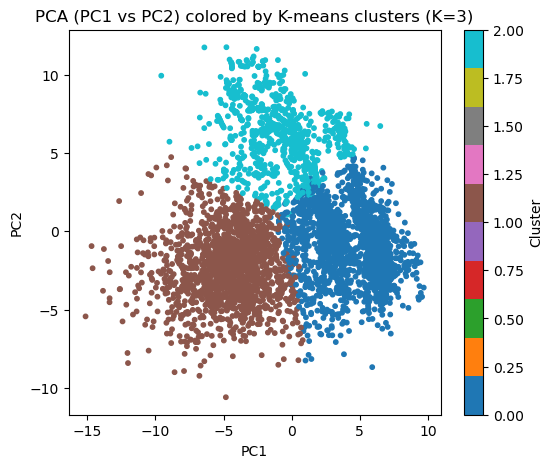

In [153]:
#visualise K=3 clusters in PCA space
plt.figure(figsize=(6,5))
plt.scatter(X_pca_red[:,0], X_pca_red[:,1], c=clusters_3, cmap="tab10", s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (PC1 vs PC2) colored by K-means clusters (K=3)") #can change PC pairs
plt.colorbar(label="Cluster")
plt.show()

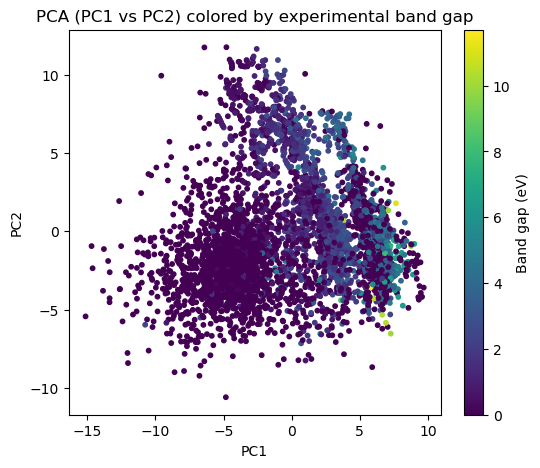

In [154]:
#visualise band gap in PCA space
plt.figure(figsize=(6,5))
plt.scatter(X_pca_red[:,0], X_pca_red[:,1], c=y, cmap="viridis", s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (PC1 vs PC2) colored by experimental band gap")
plt.colorbar(label="Band gap (eV)")
plt.show()

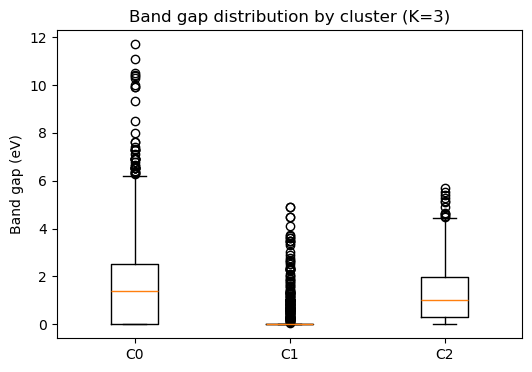

In [155]:
plt.figure(figsize=(6,4))
plt.boxplot(
    [df[df["cluster_3"] == i]["gap expt"] for i in sorted(df["cluster_3"].unique())],
    labels=[f"C{i}" for i in sorted(df["cluster_3"].unique())]
)
plt.ylabel("Band gap (eV)")
plt.title("Band gap distribution by cluster (K=3)")
plt.show()


In [159]:
def get_family(formula):
    comp = Composition(formula)
    elems = {el.symbol for el in comp.elements}
    
    hits = []
    anion_groups = {
    "oxide": {"O"},
    "halide": {"F", "Cl", "Br", "I"},
    "chalcogenide": {"S", "Se", "Te"},
    "nitride/phosphide": {"N", "P", "As", "Sb", "Bi"},
    "carbide/boride": {"C", "B"},
    "hydride": {"H"}
    }
    for name, group in anion_groups.items():
        if len(elems.intersection(group)) > 0:
            hits.append(name)
    
    if len(hits) == 0:
        return "other"
    if len(hits) == 1:
        return hits[0]
    return "mixed"
df["family"] = df["formula"].apply(get_family)

In [160]:
family_counts_3 = pd.crosstab(df["cluster_3"], df["family"], normalize="index")
display(family_counts_3.style.hide(axis="index").format("{:.2f}"))

carbide/boride,chalcogenide,halide,hydride,mixed,nitride/phosphide,other,oxide
0.00,0.29,0.05,0.00,0.37,0.04,0.00,0.25
0.11,0.05,0.00,0.00,0.01,0.13,0.69,0.01
0.01,0.40,0.02,0.00,0.35,0.16,0.05,0.01


In [1]:
!jupyter nbconvert "Phase 1.ipynb" --to html

[NbConvertApp] Converting notebook Phase 1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 28 image(s).
[NbConvertApp] Writing 2534187 bytes to Phase 1.html
